In [ ]:
from typing import TypedDict, Annotated, List, Literal, Sequence
import operator
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from IPython.display import Image, display

from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, MessagesPlaceholder, PromptTemplate, BasePromptTemplate
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema import PromptValue
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.tools import tool

from langchain.agents import AgentExecutor
from langchain.agents import create_tool_calling_agent

from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import add_messages
from langsmith import traceable

from langchain_community.utilities import OpenWeatherMapAPIWrapper
from dotenv import load_dotenv
import os

from langchain_google_genai import ChatGoogleGenerativeAI

project at: https://www.ionio.ai/blog/a-comprehensive-guide-about-langgraph-code-included

In [ ]:
load_dotenv()

# Initialize LLM
api_key = os.getenv("GOOGLE_API_KEY")
openweather_secret = os.getenv("OPENWEATHERMAP_API_KEY")

os.environ["OPENWEATHERMAP_API_KEY"] = openweather_secret
os.environ["GOOGLE_API_KEY"] = api_key

weather = OpenWeatherMapAPIWrapper()

llm_gemini = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

## Testing Weather Agent with LangGraph

In [4]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[str], operator.add]

# The workflow of the message (because we use it with operator.add so it will add up)
# -> We can use normal message (but it will not have context as clear as this)
# 0: User Query
# 1: agent return 'no_response' or 'city_name'
# 2: Weather detail

def agent(state):
  query = state["messages"]
  res = llm_gemini.invoke(f"""
    You are given one question and you have to extract city name from it

    Only reply the city name if it exists or reply 'no_response' if there is no city name in question

    Here is the question:
    {query[0]}
  """)
  return {"messages": [res.content]}


def weather_tool(state):
  context = state["messages"]
  city_name = context[1]
  data = weather.run(city_name)
  return {"messages": [data]}


def responder(state):
  agent = llm_gemini.invoke(f"""
    You have given a weather information and you have to respond to user's query based on the information

    Here is the user query:
    ---
    {state["messages"][0]}
    ---

    Here is the information:
    ---
    {state["messages"][2]}
    ---
  """)
  return {"messages": [agent.content]}


def where_to_go(state):
  ctx = state["messages"][1]
  if ctx == "no_response":
    return "end"
  else:
    return "continue"

In [5]:
workflow = StateGraph(AgentState)

workflow.add_node('agent', agent)
workflow.add_node('weather', weather_tool)
workflow.add_node("responder", responder)
# workflow.add_node("where_to_go", where_to_go)

workflow.set_entry_point("agent")   # return 'no_response' or 'city_name' in the messages state
workflow.add_conditional_edges('agent', 
                                where_to_go,      # return 'end' or 'continue' in plain text
                                {
                                    "end" : END,
                                    "continue" : "weather"
                                })
workflow.add_edge('weather', "responder")
workflow.add_edge("responder", END)

# # Create an conditional edge
# workflow.add_conditional_edges('agent', 
#                                where_to_go,{
#                             "end": END,
#                             "continue": "weather"
#                         })

# # Remaining edges
# workflow.add_edge("weather","responder")
app = workflow.compile()


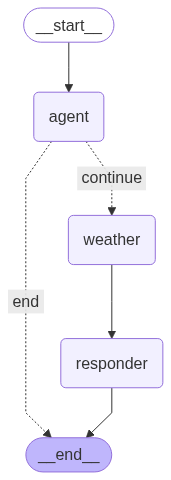

In [5]:
app

In [8]:
inputs = {"messages": ["What is the weather in Da Nang today?"]}
response = app.invoke(inputs)
print(response['messages'][-1])

The weather in Da Nang today is overcast with a temperature of 28.35°C, but it feels like 32.14°C. The wind is blowing at 4.24 m/s from a direction of 241°. Humidity is at 75% and there is 100% cloud cover.


## Testing conditional edges
Link -> https://medium.com/ai-agents/langgraph-for-beginners-part-3-conditional-edges-16a3aaad9f31

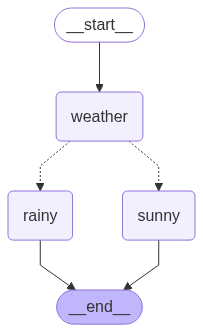

In [ ]:
import random
workflow1 = StateGraph(AgentState)

# Define a starting node. This node just returns a predefined string.
def weather(str):
  return "Hi! Well.. I have no idea... But... "

def rainy_weather(str):
  return str + " Its going to rain today. Carry an umbrella."

def sunny_weather(str):
  return str + " Its going to be sunny today. Wear sunscreen."

def forecast_weather(str)->Literal["rainy", "sunny"]:
  if random.random() < 0.5:
    return "rainy"
  else:
    return "sunny"
  

workflow1.add_node("weather", weather)
workflow1.add_node("rainy", rainy_weather)
workflow1.add_node("sunny", sunny_weather)

workflow1.add_edge(START, "weather")
workflow1.add_conditional_edges("weather", 
                                forecast_weather,
                                {
                                    "rainy": "rainy",
                                    "sunny": "sunny"
                                })
workflow1.add_edge("rainy", END)
workflow1.add_edge("sunny", END)

app = workflow1.compile()

In [ ]:
app.invoke()

## Creating agent in a Node

In [8]:
from langgraph.prebuilt import create_react_agent
from langgraph.graph import END, StateGraph

class State(TypedDict):
    messages: Annotated[list, add_messages]

@tool
def capitalize(text: str) -> str:
    """Capitalize the text."""
    print(f"Capitalizing text: {text}")
    return text.upper()

tools = [capitalize]


agent_node = create_react_agent(llm_gemini, tools)

graph = StateGraph(State)
graph.add_node("react_agent", agent_node)
graph.set_entry_point("react_agent")
graph.add_edge("react_agent", END)

agent_executor = graph.compile()

response = agent_executor.invoke({"messages": [{"role": "user", "content": "can you capitalize this text: hello world"}]})
print(response["messages"][-1].content)

Capitalizing text: hello world
HELLO WORLD
